In [1]:
import cvxpy as cp
import numpy as np
import dsp
import mosek
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

Here we perform the group dro saddle programming on $(q,\beta)$ of 3 sites with linear regression. Namely we solve $$\max_{\beta} \min_{q\in\Delta^3} \sum_{m=1}^3 q_m \dfrac{1}{n_m} \sum_{i=1}^{n_m} (y_i^2 - (y_i-x_i^T\beta)^2)$$

In using the $\texttt{dsp}$ package, objective functions should be defined through atomic functions as outlined in https://www.cvxpy.org/tutorial/functions/index.html and https://github.com/cvxgrp/dsp?tab=readme-ov-file#new-atoms

For the case of two sites and $(q,1-q)$ for $q\geq 0$, given $q$, player $\beta$'s optimal choice is to choose $$\beta = \dfrac{qX_1^T y_1 + (1-q)X_2^Ty_2}{qX_1^TX_1 + (1-q)X_2^T X_2},$$which reduces to the convex combination $\beta|X = q\beta_1+(1-q)\beta_2$ assuming covariate homogeneity.

In [6]:
beta_1 = np.array([5.78, -4.45, 1.26, 1.58, -1.14]+ [0]*45)
beta_2 = np.array([2.26, -1.05, 5.78, 6.43, -1.26]+ [0]*45)
beta_3 = np.array([1.83, -2.35, 1.34, 2.59, -6.45]+ [0]*45)

B = np.vstack([beta_1,beta_2,beta_3])
B = B.T

Sigma = 3*np.eye(50)

In [14]:
n_samples = 1000

importance = [] #importance stores the objective values
weighting = [] #weighting stores the optimal q
variable = [] #variable stores the optimal beta
stds = [] #stds stores the estimated standard deviation from the central limit theorem

for i in range(500):
    #generate the samples
    mean = np.array([0, 0, 0, 0, 0]) 
    X_1 = np.random.multivariate_normal(mean, Sigma, n_samples)
    epsilon = np.random.normal(0, 1, n_samples)
    y_1 = np.dot(X_1, beta_1) + epsilon
    
    X_2 = np.random.multivariate_normal(mean, Sigma, n_samples)
    epsilon = np.random.normal(0, 1, n_samples)
    y_2 = np.dot(X_2, beta_2) + epsilon
    
    X_3 = np.random.multivariate_normal(mean, Sigma, n_samples)
    epsilon = np.random.normal(0, 1, n_samples)
    y_3 = np.dot(X_3, beta_3) + epsilon
    
    #initiate the variable
    q = cp.Variable(3, nonneg=True)
    b = cp.Variable(50)
    
    #calculate the variable importance and define the problem
    imp_1 = cp.sum_squares(y_1 - np.mean(y_1)) - cp.sum_squares(y_1 - X_1 @ b)
    imp_2 = cp.sum_squares(y_2 - np.mean(y_2)) - cp.sum_squares(y_2 - X_2 @ b) 
    imp_3 = cp.sum_squares(y_3 - np.mean(y_3)) - cp.sum_squares(y_3 - X_3 @ b)
    
    f = dsp.saddle_inner(q,cp.hstack([imp_1,imp_2,imp_3])/ n_samples) 
    #print(f.is_dsp()) use this line to check if your function is in compliant with the saddle programming grammar
    obj = dsp.MinimizeMaximize(f)
    constraints = [cp.sum(q) == 1]
    prob = dsp.SaddlePointProblem(obj,constraints,[q],[b])
    
    try:
        prob.solve(solver="MOSEK")
        importance.append(prob.value)
        weighting.append(q.value)
        variable.append(b.value)
        #print(i)
        #the below lines re-evaluate the objective values on each samples of each site for the calculation of the 
        #estimated theoretical standard deviations given in the central limit theorem
        
        b_val = b.value
        site_1 = (y_1 - np.mean(y_1))**2 - (y_1 - X_1 @ b_val)**2
        site_2 = (y_2 - np.mean(y_2))**2 - (y_2 - X_2 @ b_val)**2
        site_3 = (y_3 - np.mean(y_3))**2 - (y_3 - X_3 @ b_val)**2
        print("run",i,":",np.round([np.mean(site_1), np.mean(site_2), np.mean(site_3)],4),np.round(q.value,4))
        site_importance = np.vstack([site_1,site_2,site_3])
        site_importance = site_importance.T
        cov = np.cov(site_importance, rowvar = False)

        var = np.dot(q.value, np.dot(cov, q.value.T))
        std_clt = np.sqrt(var/n_samples)
        stds.append(std_clt)
    except Exception as e:
        print(f"Error on iteration {i}: {e}")
        continue

ValueError: mean and cov must have same length

In [7]:
print(np.mean(variable, axis = 0),np.round(np.mean(weighting, axis = 0),4))

[0.72987216 0.50186743 0.48583203] [0.4468 0.2454 0.3077]


In [49]:
mean, std = np.mean(importance), np.std(importance)
std_est = np.mean(stds)
print(mean, std, std_est)

coverage = np.mean([(val <= mean + 2*std_est) & (val >= mean - 2*std_est) for val in importance])
print(coverage)

2.427441219784963 0.09608696276264468 0.09873486694844792
0.966


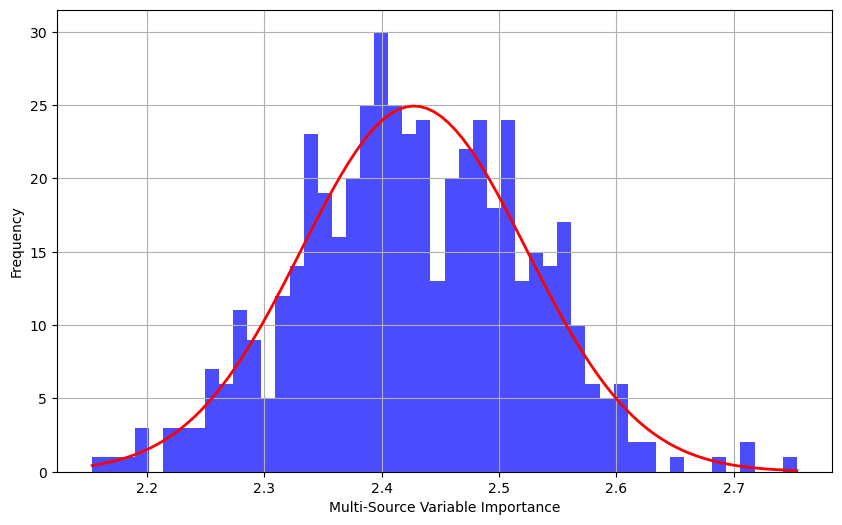

In [50]:
importance = np.array(importance)
x_values = np.linspace(importance.min(), importance.max(), 100)

bin_width = (importance.max() - importance.min()) / 50
pdf_values = stats.norm.pdf(x_values, mean, std)* bin_width * 500
plt.figure(figsize=(10, 6))
plt.hist(importance, bins=50, alpha=0.7, color='blue')
plt.plot(x_values, pdf_values, color='red', linewidth=2) 
plt.xlabel('Multi-Source Variable Importance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [51]:
stat, p_value = stats.shapiro(importance)
print(p_value)

0.44762951135635376


Here we optimize for exact solutions with proposition 1 from maximin infer (Guo, 2023)

In [7]:
G = B.T @ (Sigma @ B)
q = cp.Variable(3, nonneg = True)
objective = cp.Minimize(cp.quad_form(q, G))
constraints = [cp.sum(q) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()
print(B @ q.value, np.round(q.value,4))

[ 3.60027037 -3.04351236  2.02486524  2.77726523 -3.32305401  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ] [0.4305 0.162  0.4075]


In [8]:
np.linalg.norm(q.value)

0.6145152232997733

In [9]:
b = B @ q.value
2*(B.T@ (Sigma@b))-np.dot(b,Sigma@b)

array([135.24265069, 135.24265069, 135.24265069])

In [6]:
print(B.T @ (Sigma @ B))

[[58.5945 36.6139 34.1685]
 [36.6139 82.551  39.1292]
 [34.1685 39.1292 58.9776]]


Reward function is $V(\beta) = Y^2 - (Y-X\beta)^2$ and $\mathbb{E}(V(\beta)) = \beta^T \text{cov}(X)\beta$.

In [9]:
beta_1 = np.array([0.3,0.3])
beta_2 = np.array([-0.3,-0.8])
n_samples = 1000

importance = [] #importance stores the objective values
weighting = [] #weighting stores the optimal q
variable = [] #variable stores the optimal beta

for i in range(20):
    #generate the samples
    X_1 = np.random.uniform(-8, 8, (n_samples, 2))
    epsilon = np.random.normal(0, 1, n_samples)
    y_1 = np.dot(X_1, beta_1) + epsilon
    
    X_2 = np.random.uniform(-3, 3, (n_samples, 2))
    epsilon = np.random.normal(0, 1, n_samples)
    y_2 = np.dot(X_2, beta_2) + epsilon
    
    #initiate the variable
    q = cp.Variable(2, nonneg=True)
    b = cp.Variable(2)
    
    #calculate the variable importance and define the problem
    imp_1 = cp.sum_squares(y_1 - np.mean(y_1)) - cp.sum_squares(y_1 - X_1 @ b)
    imp_2 = cp.sum_squares(y_2 - np.mean(y_2)) - cp.sum_squares(y_2 - X_2 @ b) 
    
    f = dsp.saddle_inner(q,cp.hstack([imp_1,imp_2])/ n_samples)
    #print(f.is_dsp()) use this line to check if your function is in compliant with the saddle programming grammar
    obj = dsp.MinimizeMaximize(f)
    constraints = [cp.sum(q) == 1]
    prob = dsp.SaddlePointProblem(obj,constraints,[q],[b])
    
    try:
        prob.solve(solver="MOSEK")
        importance.append(prob.value)
        weighting.append(q.value)
        variable.append(b.value)
        
        print(i)
    except Exception as e:
        print(f"Error on iteration {i}: {e}")
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
print(np.mean(weighting, axis = 0),np.mean(variable, axis = 0))

[0.22202836 0.77797164] [ 0.09541989 -0.06440626]


In [36]:
b_1 = np.array([0.8,0.3])
b_2 = np.array([0.3,0.8])
print(np.mean((y_1 - X_1 @ b_1)**2),np.mean((y_2 - X_2 @ b_2)**2))
print(np.mean(y_1**2),np.mean(y_2**2))

1.0292483491315205 0.9837741778569163
3.240826449278722 16.00230412893565


In [42]:
def line_seg(t):
    return t*b_1 + (1-t)*b_2

vals = []
for t in np.linspace(0,1,500):
    vals.append(np.mean(y_2**2) - np.mean((y_2 - X_2 @ line_seg(t))**2))

In [44]:
np.mean(vals > (np.mean(y_1**2) - np.mean((y_1 - X_1 @ b_1)**2)))

1.0

The worst reward for the second site is better than the best reward for the first site. Therefore, irrespective of player b's choise, player q will place all mass onto the first site, and therefore player b has no choice but to move its value towards $b_1$ in order to maximize its own profit.

In [2]:
import numpy as np

# Generate X
X = np.arange(1, 11)

# Generate epsilon (random noise)
np.random.seed(0)  # For reproducibility
epsilon = np.random.normal(0, 1, 10)

# Generate Y
Y = 2 * X + epsilon

# Calculate the sample means
mean_X = np.mean(X)
mean_Y = np.mean(Y)

# Calculate the sample covariance using numpy's cov function
cov_matrix = np.cov(X, Y)
cov_XY = cov_matrix[0, 1]

# Calculate the cross-product covariance manually
cross_product_cov = np.mean((X - mean_X)[:, None] * (Y - mean_Y))

print("Sample Covariance using numpy's cov function:", cov_XY)
print("Cross-product Covariance:", cross_product_cov)

Sample Covariance using numpy's cov function: 79.70876107054829
Cross-product Covariance: -2.842170943040401e-16
